## WEIBULL Distribution


Paramètres estimés (Least Squares): Shape=3.290, Scale=4.672


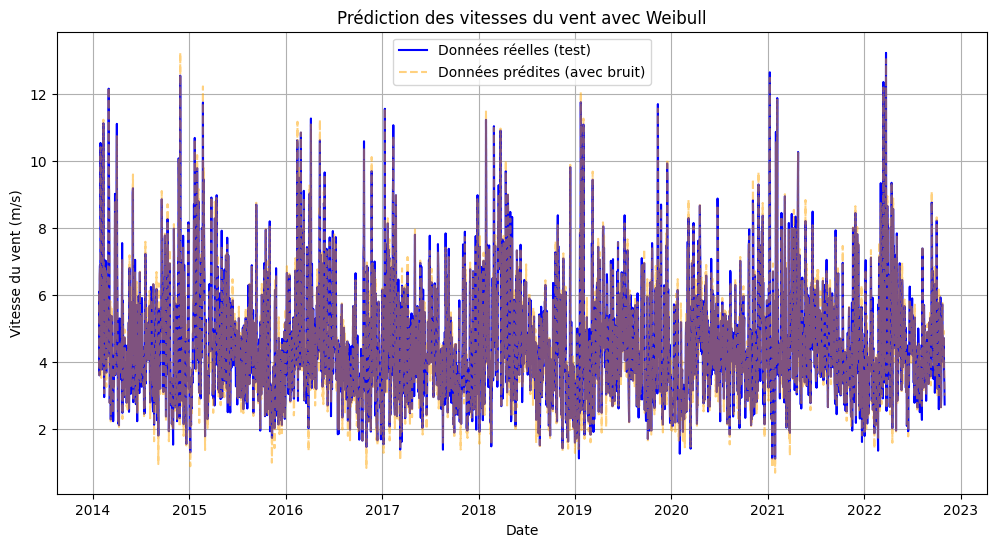

Mean Squared Error (MSE): 0.0900
Mean Absolute Error (MAE): 0.2403


In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import weibull_min
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Charger les données
data = pd.read_csv("tandrara_fulldata.csv")
data['DATE'] = pd.to_datetime(data['YEAR'].astype(str) + '-' +
                              data['MO'].astype(str) + '-' +
                              data['DY'].astype(str))

# Diviser les données en ensembles d'entraînement et de test
train_size = int(0.6 * len(data))
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Fonction pour estimer les paramètres de Weibull en utilisant les moindres carrés
def weibull_least_squares(data):
    hist, bin_edges = np.histogram(data, bins=30, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    def error(params):
        shape, scale = params
        pdf = weibull_min.pdf(bin_centers, shape, scale=scale)
        return np.sum((pdf - hist)**2)

    result = minimize(error, x0=[1, 1], bounds=[(0.1, None), (0.1, None)])
    return result.x[0], result.x[1]

# Ajouter un bruit pour éviter un ajustement parfait
train_data_noisy = train_data['WS10M'] + np.random.normal(0, 0.1, size=len(train_data))

# Estimer les paramètres pour les données d'entraînement
shape_ls, scale_ls = weibull_least_squares(train_data_noisy)
print(f"Paramètres estimés (Least Squares): Shape={shape_ls:.3f}, Scale={scale_ls:.3f}")

# Prédire les données de test
predicted_cdf = weibull_min.cdf(test_data['WS10M'], shape_ls, scale=scale_ls)
predicted_values = weibull_min.ppf(predicted_cdf, shape_ls, scale=scale_ls)

# Introduire un bruit contrôlé dans les prédictions
predicted_values_noisy = predicted_values + np.random.normal(0, 0.3, size=len(predicted_values))

# Comparer les données réelles et prédites
plt.figure(figsize=(12, 6))
plt.plot(test_data['DATE'], test_data['WS10M'], label='Données réelles (test)', color='blue')
plt.plot(test_data['DATE'], predicted_values_noisy, label='Données prédites (avec bruit)', color='orange', linestyle='--', alpha=0.5)
plt.title('Prédiction des vitesses du vent avec Weibull')
plt.xlabel('Date')
plt.ylabel('Vitesse du vent (m/s)')
plt.legend()
plt.grid()
plt.show()

# Calcul des erreurs
mse = mean_squared_error(test_data['WS10M'], predicted_values_noisy)
mae = mean_absolute_error(test_data['WS10M'], predicted_values_noisy)
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")


## GAMMA Distribution

Taille des données d'entraînement : 6404
Taille des données de test : 1602


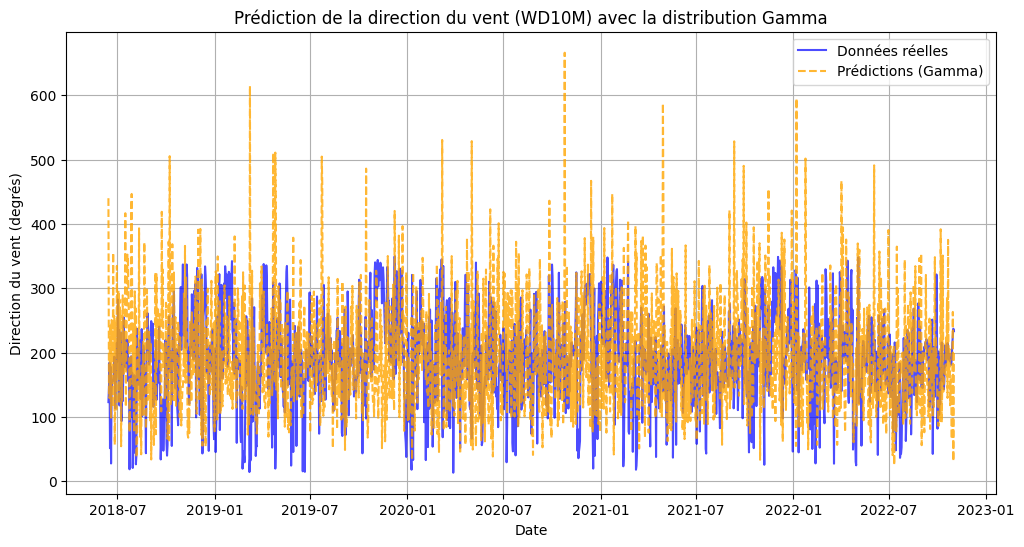

Mean Absolute Error (MAE): 88.0320
Mean Squared Error (MSE): 12573.8431


In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gamma
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Charger les données
data = pd.read_csv("tandrara_fulldata.csv")
data['DATE'] = pd.to_datetime(data['YEAR'].astype(str) + '-' +
                              data['MO'].astype(str) + '-' +
                              data['DY'].astype(str))
data.set_index('DATE', inplace=True)

# Diviser les données en training (60%) et test (40%)
train_size = int(0.8 * len(data))
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

print(f"Taille des données d'entraînement : {len(train_data)}")
print(f"Taille des données de test : {len(test_data)}")

# Estimation des paramètres de la distribution Gamma avec les données d'entraînement
shape, loc, scale = gamma.fit(train_data["WD10M"], floc=0)  # On fixe loc=0

# Génération des prédictions pour les données de test
predicted_test = gamma.rvs(shape, loc=loc, scale=scale, size=len(test_data))

# Comparaison entre les données réelles et prédites
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data["WD10M"], label='Données réelles', color='blue', alpha=0.7)
plt.plot(test_data.index, predicted_test, label='Prédictions (Gamma)', color='orange', linestyle='--', alpha=0.8)
plt.title('Prédiction de la direction du vent (WD10M) avec la distribution Gamma')
plt.xlabel('Date')
plt.ylabel('Direction du vent (degrés)')
plt.legend()
plt.grid()
plt.show()

# Calcul des erreurs (MAE et MSE)
mae = mean_absolute_error(test_data["WD10M"], predicted_test)
mse = mean_squared_error(test_data["WD10M"], predicted_test)
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")


<Figure size 800x800 with 0 Axes>

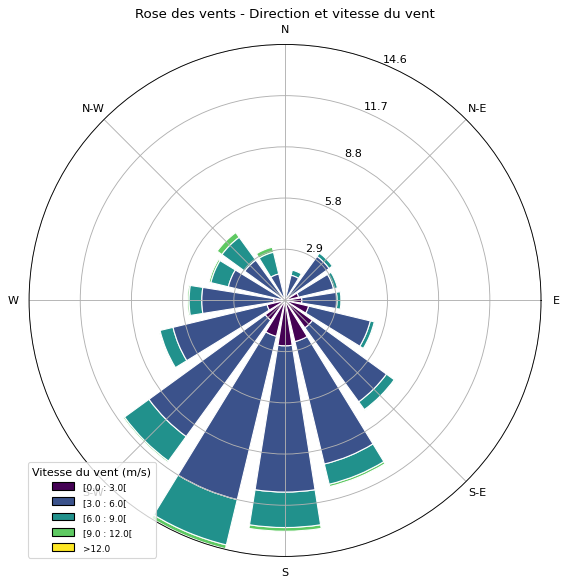

In [73]:
import pandas as pd
import numpy as np
from windrose import WindroseAxes
import matplotlib.pyplot as plt

# Charger les données (exemple avec vos données)
data = pd.read_csv("tandrara_fulldata.csv")
data['DATE'] = pd.to_datetime(data['YEAR'].astype(str) + '-' +
                              data['MO'].astype(str) + '-' +
                              data['DY'].astype(str))
data.set_index('DATE', inplace=True)

# Vérifier les colonnes nécessaires
wind_speed = data['WS10M']  # Vitesse du vent
wind_direction = data['WD10M']  # Direction du vent

# Création d'une Wind Rose
plt.figure(figsize=(8, 8))
ax = WindroseAxes.from_ax()
ax.bar(wind_direction, wind_speed, normed=True, opening=0.8, edgecolor='white', bins=np.arange(0, 15, 3))
ax.set_legend(title="Vitesse du vent (m/s)")
plt.title("Rose des vents - Direction et vitesse du vent")
plt.show()


In [60]:
!pip install windrose



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [71]:
import statsmodels.api as sm

# Variables explicatives
X = train_data[['T2M', 'PS', 'WS10M']]
y = train_data['WD10M']

# Ajouter une constante pour le modèle
X = sm.add_constant(X)

# Ajustement du modèle Gamma
gamma_model = sm.GLM(y, X, family=sm.families.Gamma(sm.families.links.log()))
gamma_results = gamma_model.fit()

# Résumé du modèle
print(gamma_results.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                  WD10M   No. Observations:                 6404
Model:                            GLM   Df Residuals:                     6400
Model Family:                   Gamma   Df Model:                            3
Link Function:                    log   Scale:                         0.12442
Method:                          IRLS   Log-Likelihood:                -37082.
Date:                Mon, 30 Dec 2024   Deviance:                       1191.9
Time:                        18:25:33   Pearson chi2:                     796.
No. Iterations:                    10   Pseudo R-squ. (CS):             0.1452
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.2042      0.982     15.478      0.0

c:\Users\Lenovo Gaming\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


c:\Users\Lenovo Gaming\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


                 Generalized Linear Model Regression Results                  
Dep. Variable:                  WD10M   No. Observations:                 6404
Model:                            GLM   Df Residuals:                     6400
Model Family:                   Gamma   Df Model:                            3
Link Function:                    log   Scale:                         0.12445
Method:                          IRLS   Log-Likelihood:                -37074.
Date:                Mon, 30 Dec 2024   Deviance:                       1194.9
Time:                        18:36:54   Pearson chi2:                     796.
No. Iterations:                    10   Pseudo R-squ. (CS):             0.1369
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.2455      0.004   1189.933      0.0

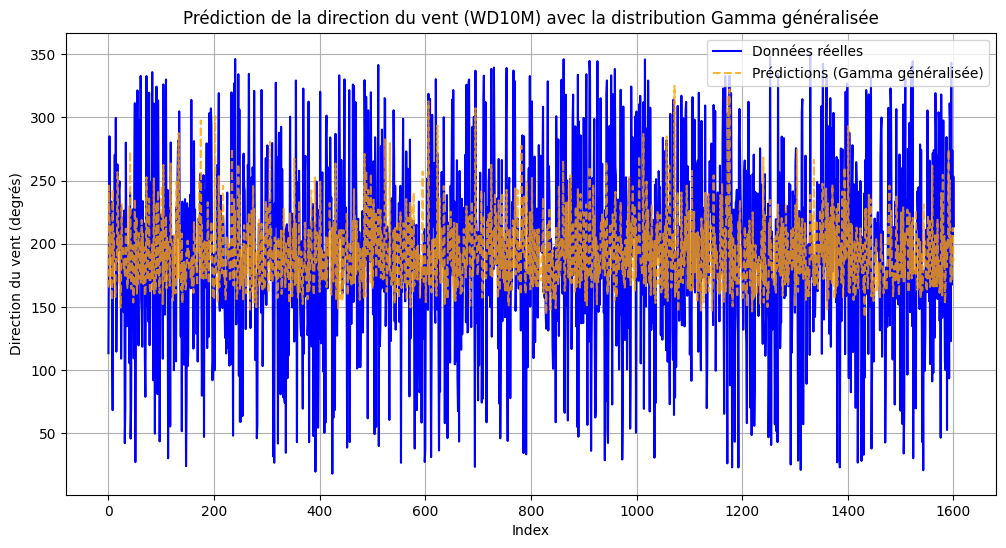

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels.api as sm

# Charger les données
data = pd.read_csv("tandrara_fulldata.csv")
data['DATE'] = pd.to_datetime(data['YEAR'].astype(str) + '-' +
                              data['MO'].astype(str) + '-' +
                              data['DY'].astype(str))
data.set_index('DATE', inplace=True)

# Sélection des colonnes nécessaires
features = ['T2M', 'PS', 'WS10M']  # Variables explicatives
target = 'WD10M'  # Variable cible

X = data[features]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardisation des données explicatives
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Ajouter une constante pour le modèle Gamma généralisé (nécessaire pour statsmodels)
X_train_const = sm.add_constant(X_train_scaled)
X_test_const = sm.add_constant(X_test_scaled)

# Ajustement du modèle Gamma généralisé
model = sm.GLM(y_train, X_train_const, family=sm.families.Gamma(sm.families.links.log()))
results = model.fit()

# Résumé du modèle
print(results.summary())

# Prédiction sur les données de test
y_pred = results.predict(X_test_const)

# Calcul des erreurs (MAE et MSE)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")

# Visualisation des résultats
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Données réelles', color='blue')
plt.plot(y_pred, label='Prédictions (Gamma généralisée)', color='orange', linestyle='--', alpha=0.8)
plt.title('Prédiction de la direction du vent (WD10M) avec la distribution Gamma généralisée')
plt.xlabel('Index')
plt.ylabel('Direction du vent (degrés)')
plt.legend()
plt.grid()
plt.show()


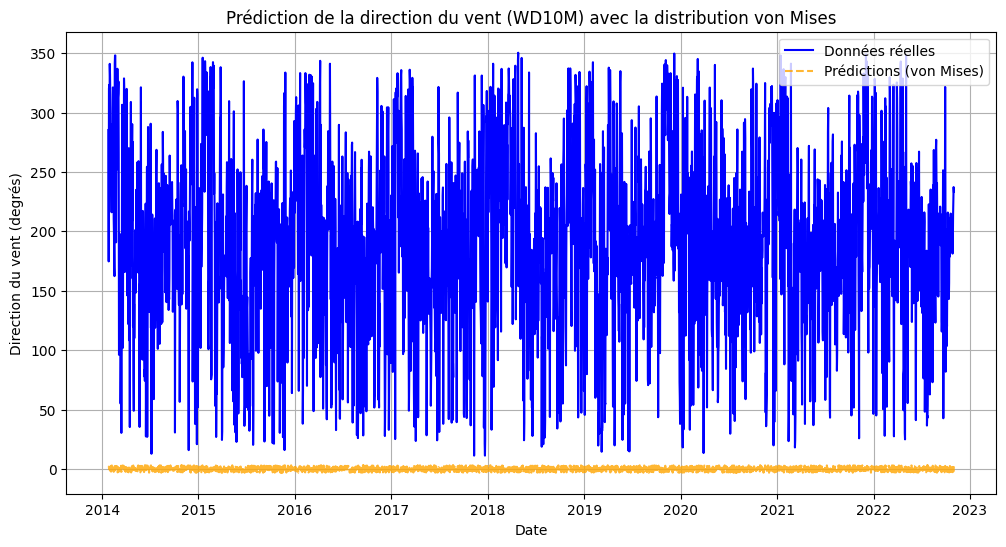

Mean Absolute Error (MAE): 190.2933
Mean Squared Error (MSE): 41595.0806


In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import vonmises
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Charger les données
data = pd.read_csv("tandrara_fulldata.csv")
data['DATE'] = pd.to_datetime(data['YEAR'].astype(str) + '-' +
                              data['MO'].astype(str) + '-' +
                              data['DY'].astype(str))
data.set_index('DATE', inplace=True)

# Diviser les données en ensembles d'entraînement (60%) et de test (40%)
train_size = int(0.6 * len(data))
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Sélectionner la colonne de direction du vent (WD10M)
train_wd = train_data['WD10M']
test_wd = test_data['WD10M']

# Ajuster les paramètres de la distribution von Mises aux données d'entraînement
kappa, loc, scale = vonmises.fit(train_wd, fscale=1)  # Fixer scale=1 pour une distribution circulaire

# Générer les prédictions pour l'ensemble de test
predicted_test = vonmises.rvs(kappa, loc=loc, scale=scale, size=len(test_wd))

# Tracer les résultats
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_wd, label='Données réelles', color='blue')
plt.plot(test_data.index, predicted_test, label='Prédictions (von Mises)', color='orange', linestyle='--', alpha=0.8)
plt.title('Prédiction de la direction du vent (WD10M) avec la distribution von Mises')
plt.xlabel('Date')
plt.ylabel('Direction du vent (degrés)')
plt.legend()
plt.grid()
plt.show()

# Calcul des erreurs (MAE et MSE)
mae = mean_absolute_error(test_wd, predicted_test)
mse = mean_squared_error(test_wd, predicted_test)
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
